이제 모델링 단계로 넘어가 보겠습니다. 참고로, 우리의 작업 계획은 다음과 같습니다:

1. 시계열을 생성하는 과정에 대한 귀중한 통찰을 추출하기 위해 데이터셋에서 EDA를 수행합니다 **(완료)**.
2. 벤치마킹을 위한 기준 모델(외생 변수 없는 단변량 모델)을 구축합니다. **(이 노트북에서 다룸)**
3. 최적의 성능을 확인하기 위해 모든 외생 변수를 포함한 단변량 모델을 구축합니다. **(이 노트북에서 다룸)**
4. 외생 변수가 있는 모델을 평가하고 잠재적인 문제를 논의합니다. **(이 노트북에서 다룸)**
5. 위에서 확인한 문제를 해결합니다. **(이 노트북에서 다룸)**
6. 최적의 모델로 미래 예측을 수행합니다.
7. 자동화된 시계열 모델링(AutoML)으로 흐름을 복제합니다.

In [1]:
# 중요한 로깅만 활성화하기 (선택 사항)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.8.13 (default, Oct 19 2022, 17:52:09)  [Clang 12.0.0 ]
executable: /Users/teddy/miniconda/envs/py38/bin/python
   machine: macOS-13.4.1-arm64-arm-64bit

PyCaret required dependencies:
                 pip: 22.2.2
          setuptools: 63.4.1
             pycaret: 3.0.4
             IPython: 8.5.0
          ipywidgets: 8.0.2
                tqdm: 4.64.1
               numpy: 1.23.4
              pandas: 1.5.1
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.1.0
            imblearn: 0.11.0
   category_encoders: 2.6.1
            lightgbm: 3.3.5
               numba: 0.57.1
            requests: 2.28.1
          matplotlib: 3.6.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.0
              sktime: 0.20.0
               tbats:

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# 노트북 전체에 대한 전역 그림 설정 ----
# 사용 중인 환경에 따라 jupyter notebook, jupyter lab, Google Colab을 사용하는 경우 renderer를 적절하게 설정해야 합니다.
# 참고: 여기서는 노트북 저장 크기를 줄이기 위해 정적 렌더러로 설정합니다.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality")

# Limiting the data for demonstration purposes.
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
target = "CO(GT)"

exclude = ['NMHC(GT)', 'AH']
data.drop(columns=exclude, inplace=True)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,index
8637,1.5,983.0,5.9,806.0,180.0,820.0,132.0,966.0,615.0,13.5,28.3,2005-03-05 15:00:00
8638,1.8,1018.0,7.3,868.0,255.0,751.0,162.0,1015.0,804.0,13.0,29.7,2005-03-05 16:00:00
8639,2.0,1101.0,8.4,916.0,251.0,721.0,159.0,1125.0,861.0,11.6,38.7,2005-03-05 17:00:00
8640,1.9,1116.0,7.7,888.0,258.0,695.0,156.0,1176.0,980.0,8.6,56.3,2005-03-05 18:00:00
8641,2.5,1161.0,9.1,945.0,344.0,654.0,177.0,1205.0,1077.0,8.5,57.9,2005-03-05 19:00:00


# 단계 2: 베이스라인 모델 - 외생 변수 없이 단일 변수 예측하기

In [6]:
data_uni = data.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,2.8%
9,Fold Generator,ExpandingWindowSplitter


In [7]:
model = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,1.5606,1.4904,1.1466,1.6039,0.6598,1.0119,-1.7616
1,2005-03-29 14:00,2.5919,1.9767,1.8655,2.1105,1.4991,0.7419,-2.7317
2,2005-03-31 14:00,1.4605,1.1539,1.0401,1.2124,1.2860,1.2780,-6.2314
Mean,NaT,1.8710,1.5403,1.3507,1.6422,1.1483,1.0106,-3.5749
SD,NaT,0.5114,0.3378,0.3666,0.3676,0.3562,0.2189,1.9197


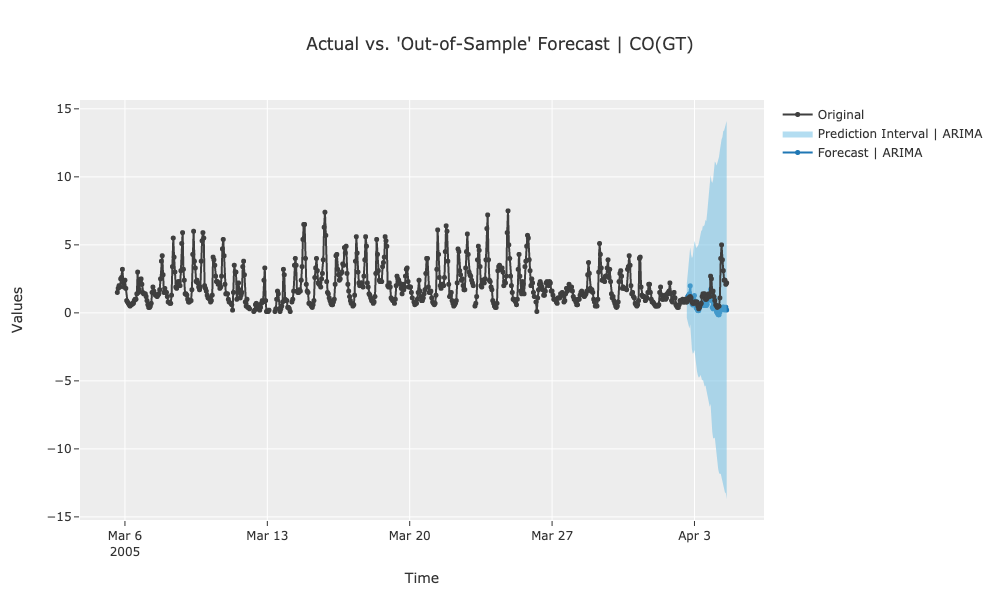

In [8]:
exp_uni.plot_model(model)

예측을 확대해 보면, 모델이 데이터셋의 일부 추세(피크)를 포착할 수 있는 것을 알 수 있지만, 모든 것을 포착하지는 못합니다. 베이스라인 모델의 성능은 CV 폴드 전체의 평균 MASE가 1.52라는 것을 보여주며, 이는 그다지 좋지 않은 성과입니다. 1보다 큰 값은 모델이 단순한 1단계 예측조차도 못 따라가고 있다는 것을 의미합니다. 이 모델은 더 개선이 필요합니다. 외생 변수를 추가하여 모델 성능을 향상시킬 수 있는지 살펴보겠습니다.


# 단계 3: 개선된 모델 - 외생 변수를 사용한 단일 변수 예측하기

In [9]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 11)"
5,Transformed data shape,"(720, 11)"
6,Transformed train set shape,"(672, 11)"
7,Transformed test set shape,"(48, 11)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [10]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.2512,0.2282,0.1846,0.2455,0.1089,0.1192,0.9353
1,2005-03-29 14:00,0.2321,0.2227,0.1670,0.2378,0.1100,0.1219,0.9526
2,2005-03-31 14:00,0.2525,0.2733,0.1798,0.2872,0.1723,0.1572,0.5943
Mean,NaT,0.2453,0.2414,0.1771,0.2568,0.1304,0.1328,0.8274
SD,NaT,0.0093,0.0227,0.0074,0.0217,0.0296,0.0173,0.1650


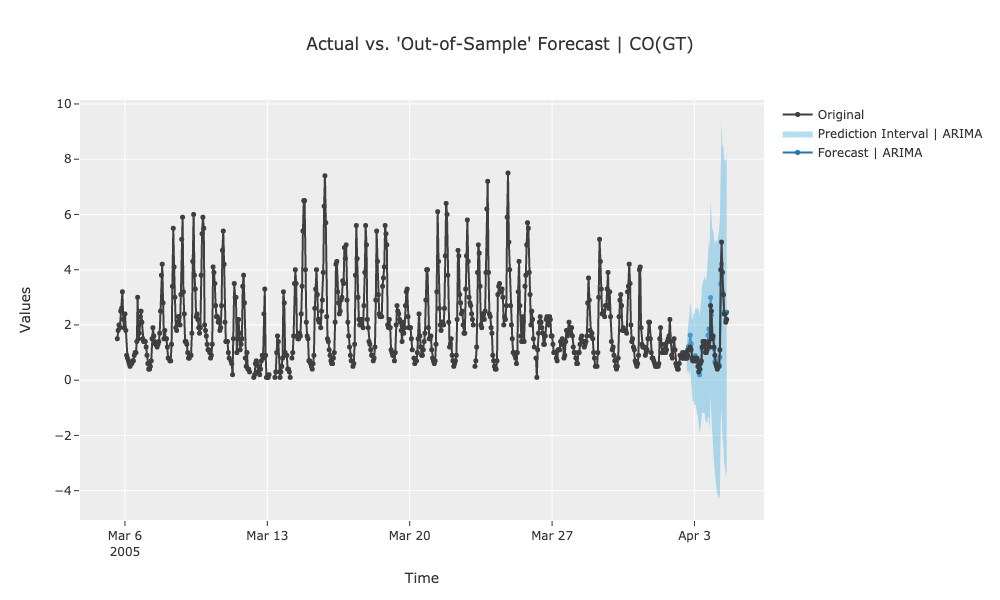

In [11]:
exp_exo.plot_model(model_exo)

# 단계 4: 모델 평가하기

나쁘지 않습니다. MASE를 상당히 향상시키는 데 성공했으며, 이는 단변량 모델보다 훨씬 좋고, 단순 모델에 비해 큰 개선입니다. 이 개선에 만족해야 합니다. 모델을 최종화하기 위해 전체 데이터셋에 대해 훈련시키고, 실제 미래 예측을 할 수 있도록 하겠습니다.

In [12]:
final_model_exo = exp_exo.finalize_model(model_exo)

In [13]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try:
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed in order to make future predictions:
['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


이 접근 방식은 부작용이 없지 않습니다. 문제는 우리가 10개의 외생 변수를 가지고 있다는 것입니다. 따라서 CO 농도의 알려지지 않은 미래 값을 얻으려면, 이러한 외생 변수들의 미래 값을 얻어야 합니다. 이는 일반적으로 일부 예측 과정을 통해 얻어집니다. 하지만 각 예측에는 오차가 있으며, 특히 외생 변수가 많을 때 이러한 오차는 복리로 증폭될 수 있습니다.

**예측 성능을 저하시키지 않으면서 이 외생 변수들을 유용한 소수의 변수로 줄일 수 있는지 살펴보겠습니다.**

# 단계 5: 간소한 모델 - 제한적인 외생 변수를 사용한 단일 변수 예측

CCF 분석에서 우리는 많은 외생 변수들이 CO 농도와 매우 유사한 상관 구조를 보인다는 것을 발견했습니다. 예를 들어, 24시간 전(`lag = 24`)의 `PT08.S1(CO)`, `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` 값은 CO 농도와 높은 양의 상관 관계를 보입니다. 이들 중에서도 `NOx(GT)`가 lag 24에서 가장 높은 양의 상관 관계를 가지는 변수입니다.

마찬가지로, 24시간 전(`lag = 24`)의 `PT08.S3(NOx)` 값은 CO 농도와 가장 높은 음의 상관 관계를 보입니다. 우리는 이 변수를 유지하기로 결정했습니다.

마지막으로, 일일 사이클에서 12시간 전에 발생한 사건도 현재 값을 영향을 줄 수 있습니다(예: 지난 밤의 값은 다음 날에 영향을 줄 수 있고 그 반대도 가능합니다). Lag = 12에서 CO 농도와 가장 높은 상관 관계를 가지는 변수는 `RH`입니다. 이 변수도 유지하기로 결정했습니다.


In [14]:
exp_slim = TSForecastingExperiment()
keep = [target, "index", 'NOx(GT)', "PT08.S3(NOx)", "RH"]
data_slim = data[keep]
exp_slim.setup(
    data=data_slim, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [15]:
model_slim = exp_slim.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.5014,0.4028,0.3684,0.4334,0.2663,0.2255,0.7983
1,2005-03-29 14:00,0.2657,0.2369,0.1912,0.2529,0.1004,0.0993,0.9464
2,2005-03-31 14:00,0.3023,0.2847,0.2153,0.2992,0.2132,0.1967,0.5596
Mean,NaT,0.3565,0.3081,0.2583,0.3285,0.1933,0.1738,0.7681
SD,NaT,0.1035,0.0697,0.0784,0.0766,0.0692,0.0540,0.1593


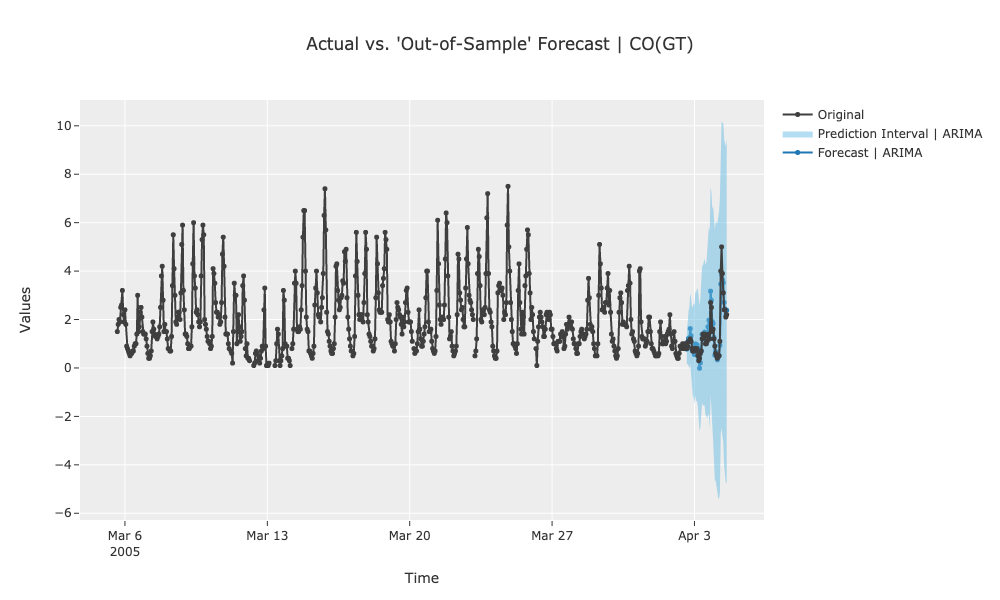

In [16]:
exp_slim.plot_model(model_slim)

나쁘지 않습니다. MASE는 약간 증가했지만, 우리는 외생 변수를 크게 줄일 수 있었습니다. 이것은 우리가 "진짜" 알려지지 않은 미래 예측을 할 때 도움이 될 것입니다. 왜냐하면 CO 농도에 대한 예측을 하기 위해 이러한 외생 변수의 "알려지지 않은" 미래 값이 필요하기 때문입니다.

# 모델 최종화하기

- 실제 미래 예측을 할 수 있도록 슬림 모델을 전체 데이터셋에 대해 훈련시킵니다.
- 배포를 위해 모델을 pickle 파일로 저장합니다.

In [17]:
final_slim_model = exp_slim.finalize_model(model_slim)

In [18]:
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [19]:
safe_predict(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


**따라서 우리는 여전히 3개의 외생 변수에 대한 미래 값을 필요로 합니다. 다음 파트에서 예측 기법을 사용하여 이를 얻을 것입니다.**

### 다음 단계는 일반적으로 새로운 세션/노트북에서 수행됩니다.

이제 우리의 모델을 구축했으니, 미래 예측을 진행해 보겠습니다. 참고로, 우리의 작업 계획은 다음과 같습니다:

1. 시계열을 생성하는 과정에 대한 귀중한 통찰을 추출하기 위해 데이터셋에서 EDA를 수행합니다 **(완료)**.
2. 벤치마킹을 위한 기준 모델(외생 변수 없는 단변량 모델)을 구축합니다 **(완료)**.
3. 최적의 성능을 확인하기 위해 모든 외생 변수를 포함한 단변량 모델을 구축합니다 **(완료)**.
4. 외생 변수가 있는 모델을 평가하고 잠재적인 문제를 논의합니다 **(완료)**.
5. 위에서 확인한 문제를 해결합니다 **(완료)**.
6. 최적의 모델로 미래 예측을 수행합니다. **(이 노트북에서 다룸)**
7. 자동화된 시계열 모델링(AutoML)으로 흐름을 복제합니다.

In [20]:
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
data = data[["index"] + exog_vars]
data.head()

,index,NOx(GT),PT08.S3(NOx),RH
8637,2005-03-05 15:00:00,180.0,820.0,28.3
8638,2005-03-05 16:00:00,255.0,751.0,29.7
8639,2005-03-05 17:00:00,251.0,721.0,38.7
8640,2005-03-05 18:00:00,258.0,695.0,56.3
8641,2005-03-05 19:00:00,344.0,654.0,57.9


# 단계 6: 미래 예측하기

# 단계 6A: 예측을 통해 미래의 외생 변수 값을 얻기

In [21]:
exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data[["index", exog_var]], target=exog_var, index="index", fh=48,
        numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
        fig_kwargs=global_fig_settings, session_id=42
    )

    # 사용자는 미래 외생 변수를 모델링하는 방법을 사용자 정의할 수 있습니다. 
    # 즉, 모델링 시간이 늘어나는 대신 더 나은 모델을 얻을 수 있는 추가 단계와 모델을 추가할 수 있습니다.
    best = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# 단계 2: 외생 변수에 대한 미래 예측 얻기
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,0.3933
theta,Theta Forecaster,1.0279,0.9437,107.4621,137.6886,0.5192,0.4990,-0.4072,0.0333
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,0.2933
exp_smooth,Exponential Smoothing,1.3411,1.2436,140.4939,181.3844,0.6563,0.9870,-2.2589,0.0600
ets,ETS,1.6539,1.5584,171.8478,226.4416,0.9317,0.5562,-4.3683,0.5400


,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.0938,1.1129,111.2510,146.6531,0.1591,0.1422,0.1075,0.0533
ets,ETS,1.3617,1.3130,138.5913,173.1125,0.1904,0.1875,-0.2074,0.1233
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.0367
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,0.1233
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,0.2767


,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3750,13.1578,0.2481,0.2286,-0.0585,0.0167
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.0300
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,0.1067
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2425,42.4920,0.7188,0.9298,-10.5261,0.0467
ets,ETS,5.3233,4.7812,37.4251,42.6863,0.7227,0.9349,-10.5908,0.0600


In [22]:
future_exog

,NOx(GT),PT08.S3(NOx),RH
2005-04-04 15:00,247.2036,648.7841,13.0838
2005-04-04 16:00,274.0699,638.3811,13.1056
2005-04-04 17:00,298.6685,606.9423,13.0876
2005-04-04 18:00,231.8742,555.6708,13.1094
2005-04-04 19:00,398.1459,501.0125,13.0913
2005-04-04 20:00,378.3662,525.9087,13.1131
2005-04-04 21:00,252.7247,600.1894,13.0951
2005-04-04 22:00,246.6336,690.9347,13.1169
2005-04-04 23:00,180.6670,724.9966,13.0988
2005-04-05 00:00,125.5157,755.4670,13.1206


# 단계 6B: 모델을 로드하고 목표 변수에 대한 미래 예측하기

In [23]:
exp_future = TSForecastingExperiment()

In [24]:
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


<AxesSubplot: >

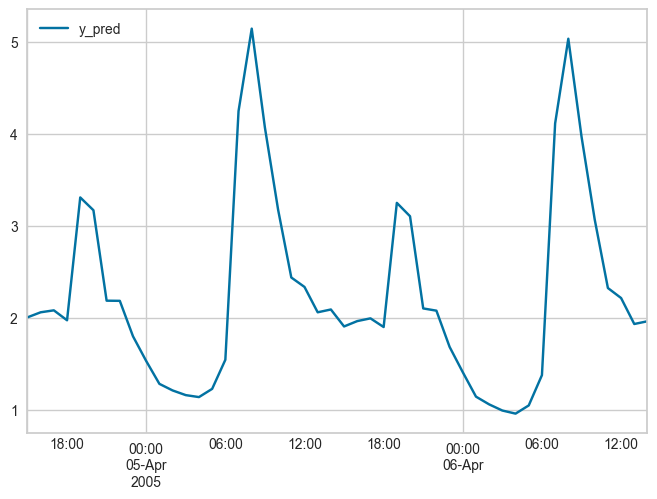

In [25]:
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
future_preds.plot()